### Using road station data from the glatmodel to improve the forecast of road surface temperature

We will use some extra information from the forecast of wind speed, wind direction, cloud cover and air temperature
to correct the prediction of TROAD
Note we are using forecast data for the features, not observational data, since the variables
above are not so widely available in all stations



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np

#just turning on to avoid warnings near plots

import warnings
warnings.filterwarnings("ignore")

In [29]:
DATADIR="/media/cap/extra_work/road_model/6h_dumps"

# Read the data from the CSV files
road_temp_df = pd.read_csv(os.path.join(DATADIR,'FYN_TROAD_glatmodel_data.csv.gz'))
wind_speed_df = pd.read_csv(os.path.join(DATADIR,'FYN_S10m_glatmodel_fcst.csv.gz'))
wind_dir_df = pd.read_csv(os.path.join(DATADIR,'FYN_D10m_glatmodel_fcst.csv.gz'))
cloud_cover_df = pd.read_csv(os.path.join(DATADIR,'FYN_CCtot_glatmodel_fcst.csv.gz'))
t2m_df = pd.read_csv(os.path.join(DATADIR,'FYN_T2m_glatmodel_fcst.csv.gz'))


# Drop unnecessary columns
road_temp_df = road_temp_df.drop(columns=['model_type', 'model_ID'])
wind_speed_df = wind_speed_df.drop(columns=['model_type', 'model_ID'])
wind_dir_df = wind_dir_df.drop(columns=['model_type', 'model_ID'])
cloud_cover_df = cloud_cover_df.drop(columns=['model_type', 'model_ID'])
t2m_df = t2m_df.drop(columns=["model_type","model_ID"])

# Rename columns for merging
wind_speed_df = wind_speed_df.rename(columns={'forecast_temp': 'S10m'})
wind_dir_df = wind_dir_df.rename(columns={'forecast_temp': 'D10m'})
cloud_cover_df = cloud_cover_df.rename(columns={'forecast_temp': 'CCtot'})
t2m_df = t2m_df.rename(columns={"forecast_temp":"T2m"})

# Convert init_time and validity_time to datetime format
road_temp_df['init_time'] = pd.to_datetime(road_temp_df['init_time'])
road_temp_df['validity_time'] = pd.to_datetime(road_temp_df['validity_time'])

wind_speed_df['init_time'] = pd.to_datetime(wind_speed_df['init_time'])
wind_speed_df['validity_time'] = pd.to_datetime(wind_speed_df['validity_time'])

wind_dir_df['init_time'] = pd.to_datetime(wind_dir_df['init_time'])
wind_dir_df['validity_time'] = pd.to_datetime(wind_dir_df['validity_time'])

cloud_cover_df['init_time'] = pd.to_datetime(cloud_cover_df['init_time'])
cloud_cover_df['validity_time'] = pd.to_datetime(cloud_cover_df['validity_time'])

t2m_df['init_time'] = pd.to_datetime(t2m_df['init_time'])
t2m_df['validity_time'] = pd.to_datetime(t2m_df['validity_time'])



# Merge the dataframes on init_time, validity_time, and lead_hrs
merged_df = pd.merge(road_temp_df, wind_speed_df, on=['site_ID', 'init_time', 'validity_time', 'lead_hrs'])
merged_df = pd.merge(merged_df, wind_dir_df, on=['site_ID', 'init_time', 'validity_time', 'lead_hrs'])
merged_df = pd.merge(merged_df, cloud_cover_df, on=['site_ID', 'init_time', 'validity_time', 'lead_hrs'])
merged_df = pd.merge(merged_df, t2m_df, on=['site_ID', 'init_time', 'validity_time', 'lead_hrs'])


#select one station and one cycle
#station_select = 302400
station_select = 335100


cycle_select = 0

merged_df = merged_df[(merged_df['init_time'].dt.hour == cycle_select) & (merged_df["site_ID"] == station_select)]

merged_df


# Sort the dataframe by validity_time
merged_df = merged_df.sort_values(by='validity_time')

# Set the date range for training and testing

train_end_date = datetime.strptime('2023-03-15', '%Y-%m-%d').replace(tzinfo=pytz.UTC)


test_start_date = datetime.strptime('2023-03-16', '%Y-%m-%d').replace(tzinfo=pytz.UTC)
test_end_date = datetime.strptime('2023-03-31','%Y-%m-%d').replace(tzinfo=pytz.UTC)
#train_end_date = datetime(2024,2,28)  # End of February
#test_start_date = datetime(2024,3,1) #'2024-03-01'  # Start of March
#test_end_date = datetime(2024,3,31)#'2024-03-31'    # End of March


In [30]:
merged_df

,site_ID,init_time,validity_time,lead_hrs,forecast_temp,TROAD,S10m,D10m,CCtot,T2m
3358,335100,2023-01-11 00:00:00+00:00,2023-01-11 06:00:00+00:00,6,7.32,7.6,9,210,1.00,8.20
3359,335100,2023-01-11 00:00:00+00:00,2023-01-11 12:00:00+00:00,12,8.47,7.7,5,211,0.24,8.19
3360,335100,2023-01-11 00:00:00+00:00,2023-01-11 18:00:00+00:00,18,5.15,4.4,6,211,0.72,6.18
3361,335100,2023-01-11 00:00:00+00:00,2023-01-12 00:00:00+00:00,24,5.89,5.3,9,182,1.00,5.95
3362,335100,2023-01-12 00:00:00+00:00,2023-01-12 06:00:00+00:00,6,4.94,3.3,5,203,1.00,5.91
...,...,...,...,...,...,...,...,...,...,...
352239,335100,2023-03-30 00:00:00+00:00,2023-03-30 18:00:00+00:00,18,8.46,8.7,6,210,1.00,8.13
352240,335100,2023-03-30 00:00:00+00:00,2023-03-31 00:00:00+00:00,24,7.95,7.5,7,232,1.00,7.67
352241,335100,2023-03-31 00:00:00+00:00,2023-03-31 06:00:00+00:00,6,8.30,7.5,3,203,1.00,7.68
352242,335100,2023-03-31 00:00:00+00:00,2023-03-31 12:00:00+00:00,12,14.38,14.0,2,168,1.00,10.44


In [31]:
# Prepare the feature matrix X and the target vector y
X = merged_df[['TROAD','S10m', 'D10m', 'CCtot','T2m']]
y = merged_df['forecast_temp']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X, y, merged_df.index, test_size=0.2, random_state=42)

# Split the data into training and testing sets based on date
train_df = merged_df[merged_df['validity_time'] <= train_end_date]
test_df = merged_df[(merged_df['validity_time'] >= test_start_date) & (merged_df['validity_time'] <= test_end_date)]

X_train = train_df[['TROAD', 'S10m', 'D10m', 'CCtot','T2m']]
y_train = train_df['forecast_temp']
X_test = test_df[['TROAD', 'S10m', 'D10m', 'CCtot',"T2m"]]
y_test = test_df['forecast_temp']



In [32]:
test_df

,site_ID,init_time,validity_time,lead_hrs,forecast_temp,TROAD,S10m,D10m,CCtot,T2m
352181,335100,2023-03-15 00:00:00+00:00,2023-03-16 00:00:00+00:00,24,1.80,-0.7,2,226,0.99,1.78
352182,335100,2023-03-16 00:00:00+00:00,2023-03-16 06:00:00+00:00,6,0.25,-1.2,2,137,1.00,1.40
352183,335100,2023-03-16 00:00:00+00:00,2023-03-16 12:00:00+00:00,12,6.99,10.0,6,144,1.00,5.36
352184,335100,2023-03-16 00:00:00+00:00,2023-03-16 18:00:00+00:00,18,3.53,5.9,9,156,1.00,3.75
352185,335100,2023-03-16 00:00:00+00:00,2023-03-17 00:00:00+00:00,24,3.69,5.0,7,156,1.00,4.13
352186,335100,2023-03-17 00:00:00+00:00,2023-03-17 06:00:00+00:00,6,4.46,4.2,5,150,1.00,4.14
352187,335100,2023-03-17 00:00:00+00:00,2023-03-17 12:00:00+00:00,12,12.43,14.9,4,164,1.00,6.78
352188,335100,2023-03-17 00:00:00+00:00,2023-03-17 18:00:00+00:00,18,9.08,9.6,2,179,1.00,8.56
352189,335100,2023-03-17 00:00:00+00:00,2023-03-18 00:00:00+00:00,24,7.86,8.1,2,176,1.00,8.00
352190,335100,2023-03-18 00:00:00+00:00,2023-03-18 06:00:00+00:00,6,7.22,6.2,2,190,1.00,7.52


In [33]:
# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict the observed road temperature on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# If you want to see the coefficients of the model
print("Model Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")


Mean Squared Error: 4.119542144647133
R-squared: 0.7427228222624958
Model Coefficients:
TROAD: 0.7218203931235964
S10m: -0.1961753658345604
D10m: 0.002370728442022685
CCtot: 0.045175465464546864
T2m: 0.33624738112366315


In [34]:
# Predict the road temperature for the test dataset
test_df['forecast_temp_model'] = model.predict(test_df[['TROAD', 'S10m', 'D10m', 'CCtot',"T2m"]])


In [35]:
# Plot only for the period I wanted to test


In [36]:
# Plot the observed vs predicted road temperatures
#plt.figure(figsize=(14, 7))
#plt.plot(X_test.index, y_test, label='Observed TROAD', color='blue', alpha=0.6)
#plt.plot(X_test.index, y_pred, label='Predicted TROAD', color='red', alpha=0.6)
#merged_test_df = merged_df.iloc[X_test.index]
# Retrieve the validity_time for the test set
#validity_time_test = merged_df.loc[test_idx, 'validity_time']


In [37]:
#X_test.index
#merged_df.iloc[X_test.index]
#validity_time_test = merged_test_df['validity_time']
#plt.figure(figsize=(14, 7))
#plt.plot(validity_time_test, y_test, label='Observed TROAD', color='blue', alpha=0.6)
#plt.plot(validity_time_test, y_pred, label='Predicted TROAD', color='red', alpha=0.6)

#plt.xlabel('Validity Time')
#plt.ylabel('Road Temperature (TROAD)')
#plt.title('Observed vs Predicted Road Temperature')
#plt.legend()
#plt.show()

In [38]:
# Calculate the bias (errors)
#original_bias = X_test['forecast_temp'] - y_test
#model_bias = y_pred - y_test


In [39]:
#model_bias

In [40]:

# Plot the original and model bias
#plt.figure(figsize=(14, 7))
#plt.plot(validity_time_test, original_bias, label='Original Forecast Bias', color='blue', alpha=0.6)
#plt.plot(validity_time_test, model_bias, label='Model Forecast Bias', color='red', alpha=0.6)

#plt.xlabel('Validity Time')
#plt.ylabel('Bias (Error)')
#plt.title('Bias (Error) of Original Forecast vs. Model Forecast')
#plt.legend()
#plt.show()

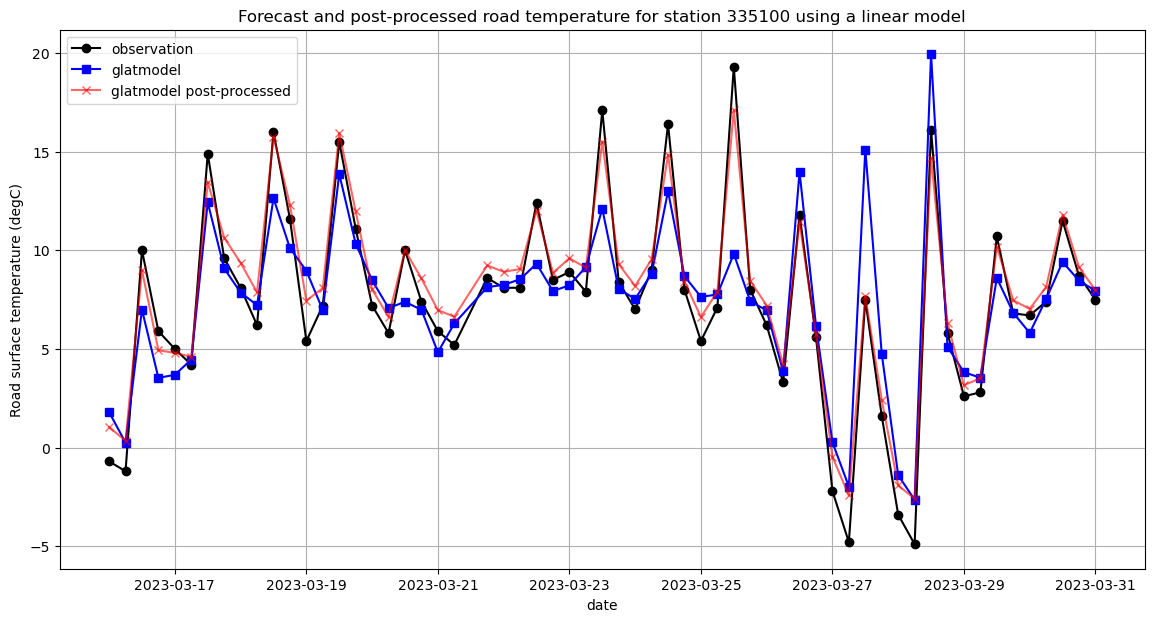

In [41]:
# Plot TROAD versus validity_time
plt.figure(figsize=(14, 7))
plt.plot(test_df['validity_time'], test_df['TROAD'], label='observation', color='black',marker="o")
plt.plot(test_df["validity_time"],test_df["forecast_temp"],label="glatmodel",color="blue",marker="s")
plt.plot(test_df['validity_time'], test_df['forecast_temp_model'], label='glatmodel post-processed', color='red', marker="x",alpha=0.6)

plt.xlabel('date')
plt.ylabel('Road surface temperature (degC)')
plt.title(f'Forecast and post-processed road temperature for station {station_select} using a linear model')
plt.legend()
plt.grid(True)

plt.show()

In [42]:
# Calculate the bias (errors)
original_bias = test_df['forecast_temp'] - test_df["TROAD"]
model_bias = test_df["forecast_temp_model"] - test_df["TROAD"]

In [43]:
#merged_df['TROAD_model'] = model.predict(X)


In [44]:
# Plot TROAD and TROAD_model against validity_time
#plt.figure(figsize=(14, 7))
#plt.plot(merged_df['validity_time'], merged_df['TROAD'], label='Observed TROAD', color='blue', alpha=0.6)
#plt.plot(merged_df['validity_time'], merged_df['TROAD_model'], label='Predicted TROAD_model', color='red', alpha=0.6)

#plt.xlabel('Validity Time')
#plt.ylabel('Road Temperature (TROAD)')
#plt.title('Observed vs Predicted Road Temperature')
#plt.legend()
#plt.show()

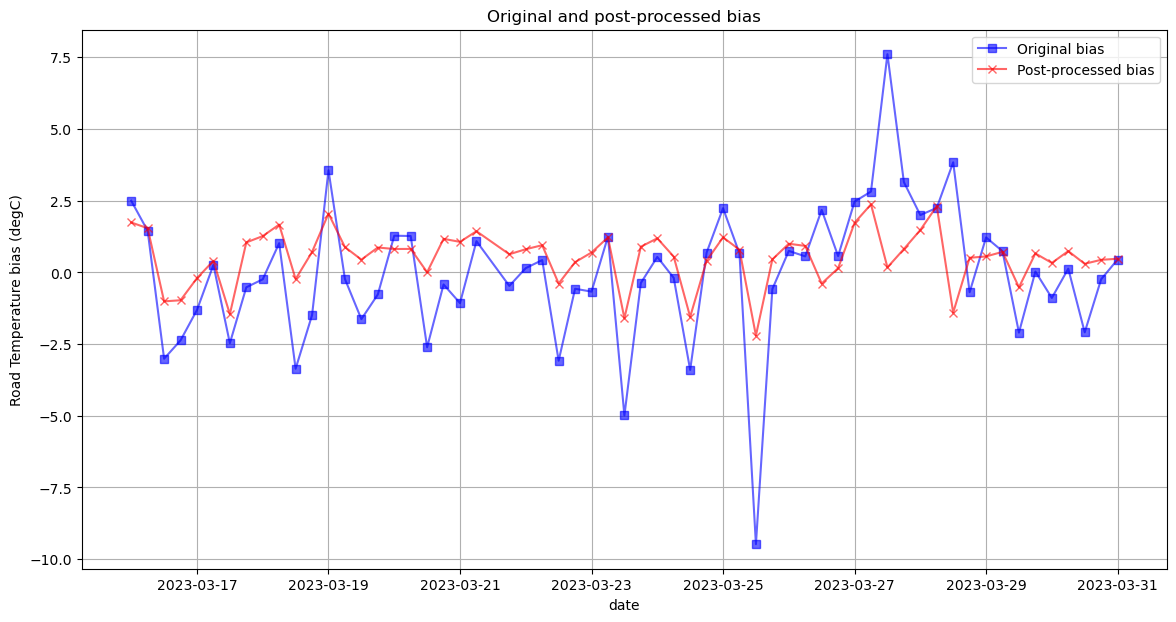

In [45]:
test_df['orig_bias'] = test_df["forecast_temp"] - test_df["TROAD"]
test_df["new_bias"] = test_df["forecast_temp_model"] - test_df["TROAD"]

# Plot TROAD and TROAD_model against validity_time
fig=plt.figure(figsize=(14, 7))
plt.plot(test_df['validity_time'], test_df['orig_bias'], label='Original bias', color='blue',marker="s", alpha=0.6)
plt.plot(test_df['validity_time'], test_df['new_bias'], label='Post-processed bias', color='red', marker="x",alpha=0.6)

plt.xlabel('date')
plt.ylabel('Road Temperature bias (degC)')
plt.title('Original and post-processed bias')
plt.legend()
plt.grid(True)

plt.show()
fig.savefig("linear_model_bias.png")


In [46]:
# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Group by lead_hrs and calculate RMSE for each group
rmse_results = []

for lead_hr, group in test_df.groupby('lead_hrs'):
    rmse_original = calculate_rmse(group['TROAD'], group['forecast_temp'])
    rmse_model = calculate_rmse(group['TROAD'], group['forecast_temp_model'])
    rmse_results.append((lead_hr, rmse_original, rmse_model))

# Convert results to a DataFrame for better readability
rmse_df = pd.DataFrame(rmse_results, columns=['lead_hrs', 'RMSE_Original', 'RMSE_Model'])



#print(rmse_df)


# Function to calculate bias (mean error)
def calculate_bias(y_true, y_pred):
    return np.mean(y_true - y_pred)

# Group by lead_hrs and calculate bias for each group
bias_results = []

for lead_hr, group in test_df.groupby('lead_hrs'):
    bias_original = calculate_bias(group['TROAD'], group['forecast_temp'])
    bias_model = calculate_bias(group['TROAD'], group['forecast_temp_model'])
    bias_results.append((lead_hr, bias_original, bias_model))

# Convert results to a DataFrame for better readability
bias_df = pd.DataFrame(bias_results, columns=['lead_hrs', 'Bias_Original', 'Bias_Model'])

#print(bias_df)
errors_df = pd.DataFrame({"lead_hr": rmse_df.lead_hrs,"RMSE_orig":rmse_df.RMSE_Original, "RMSE_pp":rmse_df.RMSE_Model,
                          "bias_orig":bias_df.Bias_Original,"bias_pp":bias_df.Bias_Model})

In [47]:
errors_df

,lead_hr,RMSE_orig,RMSE_pp,bias_orig,bias_pp
0,6,1.215908,1.292340,-0.900667,-1.155687
1,12,4.292225,1.064231,1.756429,0.701547
2,18,1.187544,0.727993,0.270000,-0.543169
3,24,1.628028,1.160705,-0.811250,-1.014221


### Testing a random forest model below

In [48]:
# Prepare the feature matrix X and the target vector y
X = merged_df[['TROAD','S10m', 'D10m', 'CCtot','T2m']]
y = merged_df['forecast_temp']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X, y, merged_df.index, test_size=0.2, random_state=42)

# Split the data into training and testing sets based on date
train_df = merged_df[merged_df['validity_time'] <= train_end_date]
test_df = merged_df[(merged_df['validity_time'] >= test_start_date) & (merged_df['validity_time'] <= test_end_date)]

X_train = train_df[['TROAD', 'S10m', 'D10m', 'CCtot','T2m']]
y_train = train_df['forecast_temp']
X_test = test_df[['TROAD', 'S10m', 'D10m', 'CCtot',"T2m"]]
y_test = test_df['forecast_temp']


In [49]:
# Create a Random Forest model
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict the road temperature for the test data
y_pred_test = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 2.7272222336666614
R-squared: 0.8296771789912512


In [50]:
test_df['forecast_temp_model'] = rf_model.predict(test_df[['TROAD', 'S10m', 'D10m', 'CCtot',"T2m"]])


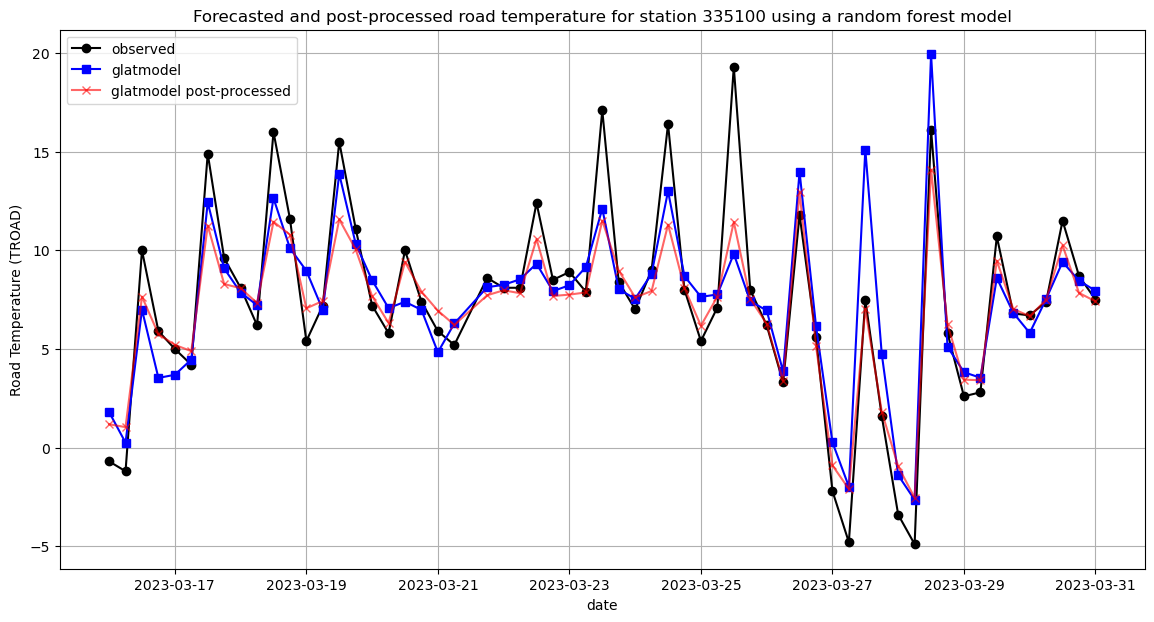

In [51]:
# Plot TROAD versus validity_time
plt.figure(figsize=(14, 7))
plt.plot(test_df['validity_time'], test_df['TROAD'], label='observed', color='black',marker="o")
plt.plot(test_df["validity_time"],test_df["forecast_temp"],label="glatmodel",color="blue",marker="s")
plt.plot(test_df['validity_time'], test_df['forecast_temp_model'], label='glatmodel post-processed', color='red', marker="x",alpha=0.6)


plt.xlabel('date')
plt.ylabel('Road Temperature (TROAD)')
plt.title(f'Forecasted and post-processed road temperature for station {station_select} using a random forest model')
plt.grid(True)

plt.legend()
plt.show()

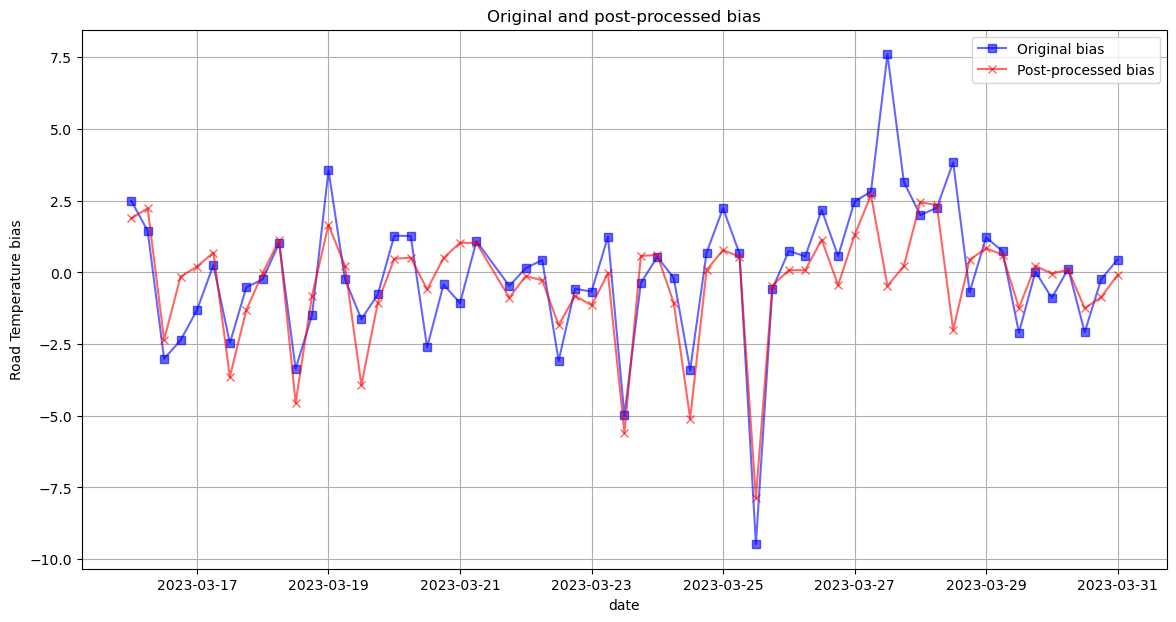

In [52]:
test_df['orig_bias'] = test_df["forecast_temp"] - test_df["TROAD"]
test_df["new_bias"] = test_df["forecast_temp_model"] - test_df["TROAD"]

# Plot TROAD and TROAD_model against validity_time
fig=plt.figure(figsize=(14, 7))
plt.plot(test_df['validity_time'], test_df['orig_bias'], label='Original bias', color='blue', marker="s",alpha=0.6)
plt.plot(test_df['validity_time'], test_df['new_bias'], label='Post-processed bias', color='red', marker="x",alpha=0.6)

plt.xlabel('date')
plt.ylabel('Road Temperature bias')
plt.title('Original and post-processed bias')
plt.grid(True)

plt.legend()
plt.show()
fig.savefig("ran_for_test.png")

In [53]:
# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Group by lead_hrs and calculate RMSE for each group
rmse_results = []

for lead_hr, group in test_df.groupby('lead_hrs'):
    rmse_original = calculate_rmse(group['TROAD'], group['forecast_temp'])
    rmse_model = calculate_rmse(group['TROAD'], group['forecast_temp_model'])
    rmse_results.append((lead_hr, rmse_original, rmse_model))

# Convert results to a DataFrame for better readability
rmse_df = pd.DataFrame(rmse_results, columns=['lead_hrs', 'RMSE_Original', 'RMSE_Model'])



#print(rmse_df)


# Function to calculate bias (mean error)
def calculate_bias(y_true, y_pred):
    return np.mean(y_true - y_pred)

# Group by lead_hrs and calculate bias for each group
bias_results = []

for lead_hr, group in test_df.groupby('lead_hrs'):
    bias_original = calculate_bias(group['TROAD'], group['forecast_temp'])
    bias_model = calculate_bias(group['TROAD'], group['forecast_temp_model'])
    bias_results.append((lead_hr, bias_original, bias_model))

# Convert results to a DataFrame for better readability
bias_df = pd.DataFrame(bias_results, columns=['lead_hrs', 'Bias_Original', 'Bias_Model'])

#print(bias_df)

errors_df = pd.DataFrame({"lead_hr": rmse_df.lead_hrs,"RMSE_orig":rmse_df.RMSE_Original, "RMSE_pp":rmse_df.RMSE_Model,
                          "bias_orig":bias_df.Bias_Original,"bias_pp":bias_df.Bias_Model})

In [54]:
errors_df

,lead_hr,RMSE_orig,RMSE_pp,bias_orig,bias_pp
0,6,1.215908,1.234004,-0.900667,-0.722280
1,12,4.292225,3.649343,1.756429,2.805836
2,18,1.187544,0.682048,0.270000,0.314620
3,24,1.628028,1.070664,-0.811250,-0.617825


In [55]:
# Calculate the differences between observed and predicted values
diff_original = test_df['forecast_temp'] - test_df['TROAD']
diff_model = test_df['forecast_temp_model'] - test_df['TROAD']

# Square the differences
squared_diff_original = diff_original ** 2
squared_diff_model = diff_model ** 2

# Compute the mean of the squared differences
mean_squared_diff_original = np.mean(squared_diff_original)
mean_squared_diff_model = np.mean(squared_diff_model)

# Take the square root of the mean squared differences to get RMSE
rmse_original = np.sqrt(mean_squared_diff_original)
rmse_model = np.sqrt(mean_squared_diff_model)

In [ ]:
### rubbish below...

In [ ]:


# Assuming your dataframe is named df
# Calculate the forecast error
df['forecast_error'] = df['observed_road_temp'] - df['forecasted_road_temp']

# Prepare the feature matrix X and the target vector y
X = df[['time_of_day', 'observed_air_temp', 'observed_wind_speed', 'observed_wind_direction']]
y = df['forecast_error']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict the forecast error on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# If you want to see the coefficients of the model
print("Model Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")
